In [2]:
import numpy as np 
from matplotlib import pyplot as plt
import scipy
from PIL import Image
import cv2 as cv
from final_v2_opti import acopa

MEDIAN CUT

error: OpenCV(4.8.1) :-1: error: (-5:Bad argument) in function 'cvtColor'
> Overload resolution failed:
>  - src is not a numpy array, neither a scalar
>  - Expected Ptr<cv::UMat> for argument 'src'


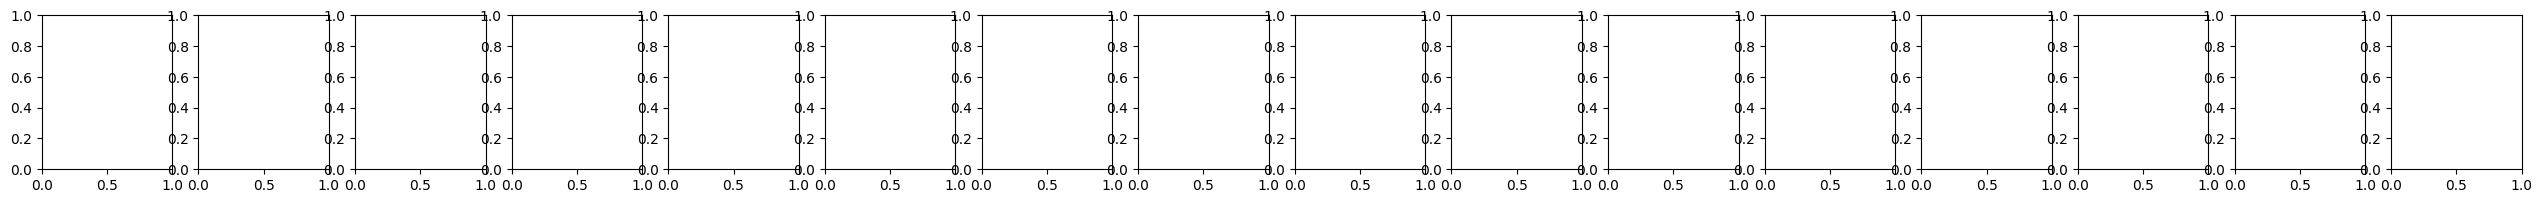

In [ ]:
def median_cut(image, n_colors):
    # Charger l'image
    im = cv.imread(image)
    assert im is not None, "file could not be read, check with os.path.exists()"

    # Convertir l'image en une liste de pixels
    pixels = im.reshape(-1, 3)  # Plus besoin de boucles, tout est dans un tableau NumPy

    # Initialiser la liste des buckets avec tous les pixels
    buckets = [pixels]

    # Boucle tant que le nombre de buckets est inférieur au nombre de couleurs souhaité
    while len(buckets) < n_colors:
        # Trouver le bucket à diviser
        new_buckets = []
        for bucket in buckets:
            if len(bucket) == 0:
                continue

            # Calculer la plage de chaque canal (R, G, B)
            r_range = np.ptp(bucket[:, 0])  # np.ptp donne la range (max - min)
            g_range = np.ptp(bucket[:, 1])
            b_range = np.ptp(bucket[:, 2])

            # Choisir le canal avec la plus grande plage
            channel = np.argmax([r_range, g_range, b_range])

            # Trier les pixels par la valeur du canal choisi
            bucket = bucket[bucket[:, channel].argsort()]

            # Séparer le bucket en deux
            half = len(bucket) // 2
            new_buckets.append(bucket[:half])
            new_buckets.append(bucket[half:])

        buckets = new_buckets

    # Calculer la couleur moyenne de chaque bucket
    palette = [np.mean(bucket, axis=0) for bucket in buckets if len(bucket) > 0]

    return palette

# Test
image = r'./images_test/test1.jpg'
n_colors = 9
palette = median_cut(image, n_colors)

# Fonction pour afficher les couleurs
def display_palette(palette):
    fig, ax = plt.subplots(1, len(palette), figsize=(len(palette) * 2, 2))

    for i, color in enumerate(palette):
        ax[i].imshow([[color / 255]])  # Diviser par 255 pour normaliser les couleurs (0-1)
        ax[i].axis('off')  # Enlever les axes pour un meilleur affichage

    plt.show()

display_palette(palette)

for color in palette:
    print(color)

## attribuer aux pixels de l'image les couleurs de la palette

def assign_colors(image, palette):
    #charger l'image
    im = cv.imread(image)
    assert im is not None, "file could not be read, check with os.path.exits()"
    #convertir l'image en une liste de pixels
    pixels = im.reshape(-1,3)
    #initialiser la liste des couleurs
    colors = []
    #boucle sur les pixels
    for pixel in pixels:
        #calculer la distance entre le pixel et chaque couleur de la palette.
        distances = np.linalg.norm(palette - pixel, axis=1)
        #trouver l'indice de la couleur la plus proche
        closest_index = np.argmin(distances)
        #attribuer la couleur correspondante
        colors.append(palette[closest_index])
        #convertir la liste en tableau NumPy
    colors = np.array(colors, dtype=np.uint8)
        #convertir le tableau en image
    output = colors.reshape(im.shape)
    return output

# Test

output = assign_colors(image,palette)
# Convert BGR to RGB
output_rgb = cv.cvtColor(output, cv.COLOR_BGR2RGB)
plt.imshow(output_rgb)
plt.axis('off')  # Masquer les axes
plt.show()

K-MEANS

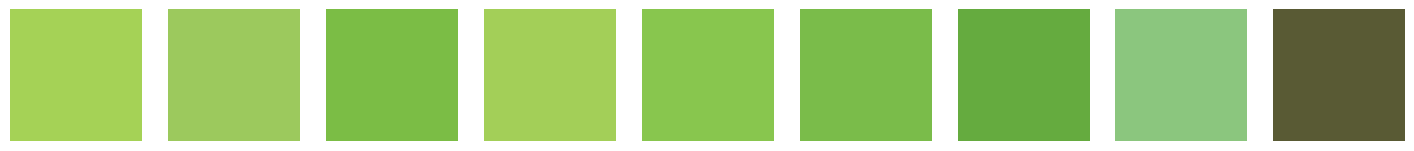

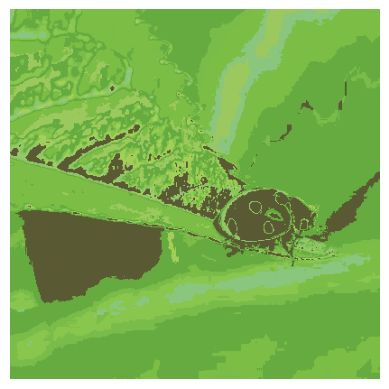

In [57]:
image = plt.imread(r'./images_test/coccinelle-sur-une-plante-carre.jpg')

clusters = 9

def distance_rgb (pix1, pix2):
    return np.sqrt((pix1[0] - pix2[0])**2 + (pix1[1] - pix2[1])**2 + (pix1[2] - pix2[2])**2)

def init_centroides(clusters,image) : 
    indices_x = np.random.randint(0, image.shape[0], size=clusters)
    indices_y = np.random.randint(0, image.shape[1], size=clusters)
    centroides = image[indices_x, indices_y]
    return centroides
    


def recalcule_centroides(partitions, centroides, image):

    for i in range(clusters):
        points = partitions[i]
        if points:
            coords = np.array(points)
            avg = np.mean(image[coords[:, 0], coords[:, 1]], axis=0)
            centroides[i] = avg
    return centroides

def iter_k_means(image, centroides):
    # Initialiser les partitions
    nv_partitions = [[] for _ in range(len(centroides))]
    
    # Reshape l'image pour avoir une liste de pixels
    pixels = image.reshape(-1, image.shape[2])
    
    # Calculer les distances entre chaque pixel et les centroides
    distances = np.linalg.norm(pixels[:, np.newaxis] - centroides, axis=2)
    
    # Trouver le cluster le plus proche pour chaque pixel
    clusters = np.argmin(distances, axis=1)
    
    # Reshape les indices des pixels pour correspondre à l'image originale
    indices = np.indices(image.shape[:2]).reshape(2, -1).T
    
    # Assigner chaque pixel au cluster correspondant
    for idx, cluster in zip(indices, clusters):
        nv_partitions[cluster].append(tuple(idx))
    
    return nv_partitions

def k_means(image,clusters,iterations) : 
    centroides = init_centroides(clusters,image)
    
    for i in range(iterations) : 
        partitions = iter_k_means(image,centroides)
        centroides =recalcule_centroides(partitions,centroides,image)
    return centroides, partitions
        
centroides,partitions = k_means(image,clusters,12)


def apply_partitions(image, partitions, centroides):
    new_image = np.copy(image)
    for i in range (clusters) : 
         cluster = partitions[i]
         for x,y in cluster : 
              new_image[x,y] = centroides[i]     
    return new_image

# Example usage
palette = centroides
new_image = apply_partitions(image, partitions, centroides)
img = Image.fromarray(new_image)
def display_palette(palette):
    fig, ax = plt.subplots(1, len(palette), figsize=(len(palette) * 2, 2))

    for i, color in enumerate(palette):
        ax[i].imshow([[color / 255]])  # Diviser par 255 pour normaliser les couleurs (0-1)
        ax[i].axis('off')  # Enlever les axes pour un meilleur affichage

    plt.show()

display_palette(palette)

plt.imshow(img)
plt.axis('off')  # Masquer les axes
plt.show()


[112.18130312 114.22096317 113.20113314 ... 114.22096317 116.26062323
 116.26062323]
Final segmentation: [  0  29 172 179]


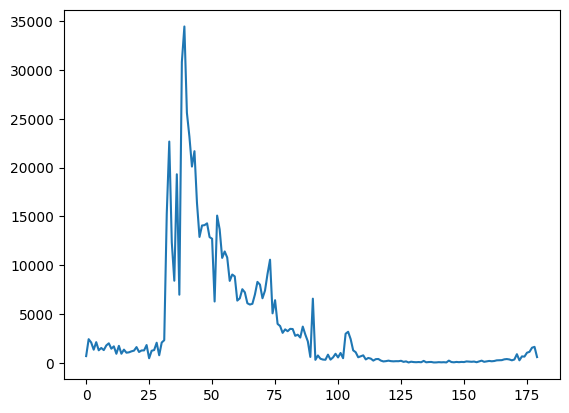

segmentation des teintes [  0.  58. 344. 358.]
180
segment_saturations {0: array([0.40389627, 0.37234174, 0.36842992, ..., 0.00080124, 0.02880889,
       0.01320383]), 1: array([0.46010275, 0.46509762, 0.50384368, ..., 0.16956167, 0.16222913,
       0.16222913]), 2: array([0.00985457, 0.02117686, 0.02075592, ..., 0.29416649, 0.03955565,
       0.01450636])}
segment_saturations[i] [0.40389627 0.37234174 0.36842992 ... 0.00080124 0.02880889 0.01320383]
Final segmentation: [  1 178]
segment_saturations[i] [0.46010275 0.46509762 0.50384368 ... 0.16956167 0.16222913 0.16222913]
Final segmentation: [  0 178]
segment_saturations[i] [0.00985457 0.02117686 0.02075592 ... 0.29416649 0.03955565 0.01450636]
Final segmentation: [  0 134 178]
Final segmentation: [  1 178]
Final segmentation: [  0 178]
Final segmentation: [  1 146 177]
Final segmentation: [  1  53  71 104 155 178]
9


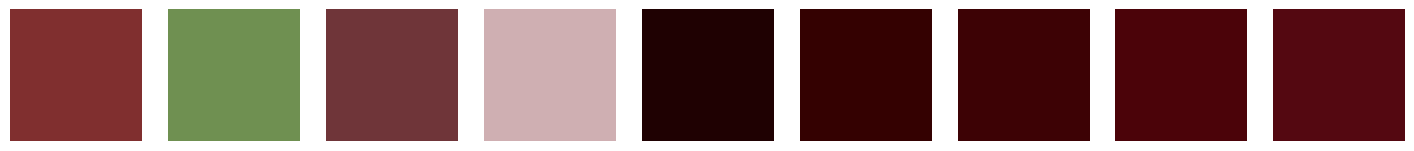

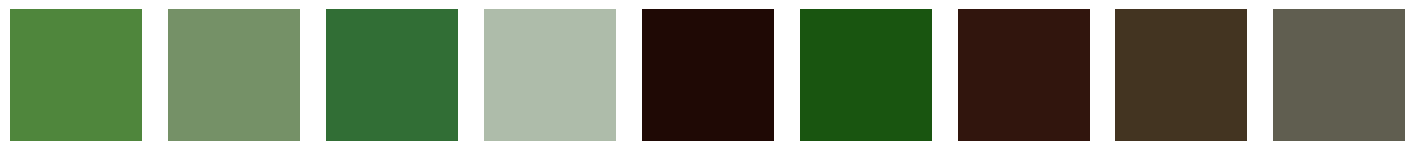

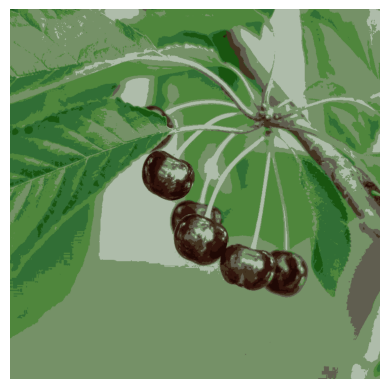

In [65]:
# Charger l'image
#image = plt.imread('./images_test/test_cerises.jpeg')
image_name = r'./images_test/test_cerises.jpg'


# Paramètres
#clusters = 20  # Nombre de clusters souhaités
iterations = 12  # Nombre d'itérations

import numpy as np 
from matplotlib import pyplot as plt
import scipy
from PIL import Image


#clusters = 20
def display_palette(palette):
    fig, ax = plt.subplots(1, len(palette), figsize=(len(palette) * 2, 2))

    for i, color in enumerate(palette):
        ax[i].imshow([[color / 255]])  # Diviser par 255 pour normaliser les couleurs (0-1)
        ax[i].axis('off')  # Enlever les axes pour un meilleur affichage

    plt.show()

def display_palette_1(palette): #pour les couleurs déjà normalisées
    fig, ax = plt.subplots(1, len(palette), figsize=(len(palette) * 2, 2))

    for i, color in enumerate(palette):
        ax[i].imshow([[color]])  # Diviser par 255 pour normaliser les couleurs (0-1)
        ax[i].axis('off')  # Enlever les axes pour un meilleur affichage

    plt.show()


def distance_rgb (pix1, pix2):
    return np.sqrt((pix1[0] - pix2[0])**2 + (pix1[1] - pix2[1])**2 + (pix1[2] - pix2[2])**2)

def init_centroides(image) : 
    centroides = acopa(image)
    display_palette_1(centroides)
    return centroides
    


def recalcule_centroides(partitions, centroides, image):
    image = plt.imread(image)
    for i in range(len(centroides)):
        points = partitions[i]
        if points:
            coords = np.array(points)
            avg = np.mean(image[coords[:, 0], coords[:, 1]], axis=0)
            centroides[i] = avg
    return centroides

def iter_k_means(image, centroides):
    image = plt.imread(image)
    # Initialiser les partitions
    nv_partitions = [[] for _ in range(len(centroides))]
    
    # Reshape l'image pour avoir une liste de pixels
    pixels = image.reshape(-1, image.shape[2])
    
    # Calculer les distances entre chaque pixel et les centroides
    distances = np.linalg.norm(pixels[:, np.newaxis] - centroides, axis=2)
    
    # Trouver le cluster le plus proche pour chaque pixel
    clusters = np.argmin(distances, axis=1)
    
    # Reshape les indices des pixels pour correspondre à l'image originale
    indices = np.indices(image.shape[:2]).reshape(2, -1).T
    
    # Assigner chaque pixel au cluster correspondant
    for idx, cluster in zip(indices, clusters):
        nv_partitions[cluster].append(tuple(idx))
    
    return nv_partitions

def k_means(image,iterations) : 
    centroides = init_centroides(image)
    
    for i in range(iterations) : 
        partitions = iter_k_means(image,centroides)
        centroides =recalcule_centroides(partitions,centroides,image)
    return centroides, partitions
        
centroides,partitions = k_means(image_name,20)


def apply_partitions(image, partitions, centroides):
    image = plt.imread(image)
    new_image = np.copy(image)
    for i in range (len(centroides)) : 
         cluster = partitions[i]
         for x,y in cluster : 
              new_image[x,y] = centroides[i]     
    return new_image

# Example usage
new_image = apply_partitions(image_name, partitions, centroides)
img = Image.fromarray(new_image)
palette = centroides

display_palette(palette)
plt.imshow(img)
plt.axis('off')  # Masquer les axes
plt.show()
